# Geospatial Analytics

In this lab and exercise, we'll examine geospatial data related to bus stops and addresses and use it to answer some questions.

The data we'll be working with is available directly from [COTA](https://www.cota.com/data/) and the [City of Columbus](data-columbus.opendata.arcgis.com).  

As a reminder, press SHIFT+ENTER or press the *Run Cell* button to execute the code in a selected cell. For the lab, you do not need to add any code - just follow along.  For the exercise, you will have to write one line of code.

## Lab

In this lab, we'll use the data mentioned above to answer a question related to bus availability.  For a given address and a set of bus stops, we can calculate the distance to the nearest bus stop.  For a collection of addresses, we can calculate the distance to the nearest stop for each of them.  We can than determine what the greatest distance is from this set of calculations as a way of measuring how accessible public transportation is in an area.

Though the City of Columbus' Address dataset contains over 750,000 addresses for Franklin county and areas within 7 miles of the county, we'll work with a much smaller subset: the addresses in the [43222](https://www.google.com/maps/place/Columbus,+OH+43222/@39.96022,-83.0547451,14z/data=!3m1!4b1!4m5!3m4!1s0x88388f0a41e5927d:0x39750e5a4bb09747!8m2!3d39.9591613!4d-83.0334524) zip code.  This reduction is necessary given time and resource limitations.

### Libraries

To conduct this analysis, we'll make use of several third-party libraries:

- [geopandas](http://geopandas.org/): an extension of the pandas library for organizing and working with geospatial data.
- [haversine](https://github.com/mapado/haversine): a library that provides functionality to calculate the distance between two points on earth using the [haversine formula](https://en.wikipedia.org/wiki/Haversine_formula).
- [matplotlib](https://matplotlib.org/): a library used to generate plots; while we won't make use of the library directly, many other libraries rely on matplotlib to generate plots.
- [requests](http://docs.python-requests.org/en/master/): a library that provides a simple way making HTTP requests to get resources from the web.

As a first step, we'll make sure these libraries are installed. Some might already be installed in the environment in which the notebook is run.

In [6]:
!pip3 install geopandas haversine matplotlib requests 

  Using cached haversine-0.4.5.tar.gz
  Running setup.py bdist_wheel for haversine ... done
  Stored in directory: /Users/arthur/Library/Caches/pip/wheels/be/a3/4e/2e073dc725bf9b430e2d42931c55e5be2be4cdc6e325e17677
Successfully built haversine


Now that the third-party libraries are installed, we have to use `import` to load them to make use of them.  In addition to the libraries listed above, we'll also load components from the [standard library](https://docs.python.org/3/library/index.html) - code included with a standard installation of Python that provides additional functionality:

- [io](https://docs.python.org/3/library/io.html): tools for working with [streams](https://en.wikipedia.org/wiki/Stream_%28computing%29) of data.
- [itertools](https://docs.python.org/3/library/itertools.html): a collection of utilities to support efficient iteration through collections.
- [zipfile](https://docs.python.org/3/library/zipfile.html): tools for working with zip files.

Additionally, we'll use the `from...import` syntax to import a specific component from the *matplotlib* library.

In [7]:
import io
import itertools
import zipfile

import geopandas
import haversine
import requests
import shapely

from matplotlib import pyplot

As mentioned previously, matplotlib will be used to generate plots.  To provide a nicer integration with the notebook, we'll first indicate that we'd like generate plots to be show in the notebook itself and then set the figure size to have a value greater than the default.

In [8]:
%matplotlib inline
pyplot.rcParams["figure.figsize"] = (10, 10)

### COTA Data

Now that we've loaded the necessary libraries, let's work with the COTA data.  The data for COTA bus stops is available at the URL below.  As a first step, we'll store this URL in a variable named *cota_data_url*.

In [9]:
cota_data_url = "http://cota1974.maps.arcgis.com/sharing/rest/content/items/43e38988fab145e4934d6c6d7b3c2385/data"

If you were to open that URL in a browser, the site would return a zip file that would be saved to the computer.  Rather than download the zip file and process it outside the notebook, we can use Python and do the necessary work in the notebook.

First, we use the *Requests* library to make an [HTTP GET](https://www.w3schools.com/tags/ref_httpmethods.asp) request using the URL we specified above.  The response to our request is stored in the *cota_data* variable.

The response data is actually that of a zip file.  In order to interact with the data as a zip file, we need to first have Python convert it into a stream of binary data using the *io* library.  The resulting stream is stored in the *cota_data_stream* variable.

After converting the data into a binary stream, we can use the *zipfile* library to create an object that will allow us to interact with the data as a zip file, listing files, extracting data, etc. We'll store the zip file object in a variable named *cota_data_zip*.

In [10]:
cota_data = requests.get(cota_data_url)
cota_data_stream = io.BytesIO(cota_data.content)
cota_data_zip = zipfile.ZipFile(cota_data_stream)

Now that we have an object that we can treat like a zip file, we can use the *namelist* function to see all the files contained in the zip file itself.

In [11]:
cota_data_zip.namelist()

['Stops_201709.shx',
 'Lines_201709.cpg',
 'Lines_201709.dbf',
 'Lines_201709.prj',
 'Lines_201709.sbn',
 'Lines_201709.sbx',
 'Lines_201709.shp',
 'Lines_201709.shp.xml',
 'Lines_201709.shx',
 'Stops_201709.cpg',
 'Stops_201709.dbf',
 'Stops_201709.prj',
 'Stops_201709.sbn',
 'Stops_201709.sbx',
 'Stops_201709.shp',
 'Stops_201709.shp.xml']

These are [common](http://gisgeography.com/arcgis-shapefile-files-types-extensions/) [ESRI ArcGIS](http://www.esri.com/arcgis/about-arcgis) file formats that are used to describe geographic features. In this case, we have two sets of data: one corresponding to bus routes and one corresponding to bus stops. We're interested in the bus stops.  

In order to use the data, we first have to extract the files from the zip file. To do this, we an use the *extractall* method on *ZipFile* objects.

In [12]:
cota_data_zip.extractall()

Now that files have been extracted from the zip file, we can load the bus stop data using the *Geopanadas* library and store it in a variable named *cota_stops* and see how many records are included in the dataset.

In [13]:
cota_stops = geopandas.read_file('Stops_201709.shp')
len(cota_stops)

2992

Now that the data has been loaded, we can begin examining it.  *Geopandas* extends the *pandas* library and the *pandas* library makes use of a tabular data structure knowns as a *[GeoDataFrame](http://geopandas.org/data_structures.html#geodataframe)*.  We can examine the first five records of the table created from the bus stop data using the *head* method.

In [14]:
cota_stops.head(5)

,StopId,StopName,Lon,Lat,Comments,tpField00,FacingDir,CurbType,InService,Bench,...,tpField05,tpField07,tpField08,tpField09,RouteList,created_us,created_da,last_edite,last_edi_1,geometry
0,5217,PICKFORDE DR & BETHEL RD,-83086596,40065959,Geocoded 630' N of Bethel per MetaVue,Nr,S,,1,0,...,0,0,1,1,"001, 021, 033, 072",,None,,None,POINT (1804315.800138637 753014.3560403883)
1,6845,2425 BETHEL RD,-83084106,40064526,,Nr,E,,1,0,...,0,0,0,0,"001, 033, 072",,None,,None,POINT (1805009.347636059 752487.8177233934)
2,5225,BETHEL RD & WOOD RUN BLVD,-83080785,40064408,,Far,E,,1,0,...,0,0,0,0,"001, 033, 072",,None,,None,POINT (1805938.602667302 752438.8361940533)
3,5609,BETHEL RD & HEDGEROW RD,-83077475,40064300,,Far,E,,1,0,...,0,0,0,0,"001, 033, 072",,None,,None,POINT (1806864.80553931 752393.5515077263)
4,5218,BETHEL RD & DIERKER RD,-83074360,40064184,,Far,E,,1,0,...,,,,,"001, 072",,None,,None,POINT (1807736.413048059 752345.7336899787)


From the first five rows, we can see examples of data stored in each column.  Notice that not all the columns are displayed due to the number of columns available.  To see data for all the columns, we can either increase the number of columns that are displayed by default or examine an individual record using the *iloc* object associated with a *GeoDataFrame*.  The *iloc* object can be treated like a collection of items so we can access individual elements using the bracket notation and specifying the index of the element we're interested in.  We'll look at the first row.

In [15]:
cota_stops.iloc[0]

StopId                                               5217
StopName                         PICKFORDE DR & BETHEL RD
Lon                                             -83086596
Lat                                              40065959
Comments            Geocoded 630' N of Bethel per MetaVue
tpField00                                              Nr
FacingDir                                               S
CurbType                                                 
InService                                               1
Bench                                                   0
Shelter                                                 1
Lighting                                                0
Garbage                                                 1
Telephone                                               0
SignPost                                                1
Bicycle                                                 0
Transfer                                                1
UserShort3    

One important field to note is *geometry*.  Each bus stop can be considered in terms of a point on a map. The coordinates of each point are given by the values displayed in the *geometry* field.  For our analysis, it would be nice if these coordinates corresponded to longitude and latitude but it doesn't appear to be the case.  

A common issue with mapping is choosing how to represent the surface of a three-dimensional object, such as the earth, in a two-dimensional plane, such as a map.  This problem has led to the development of different solutions based on different [projections](https://en.wikipedia.org/wiki/Map_projection) and [coordinate systems](https://en.wikipedia.org/wiki/Geodetic_datum).  To see the projection being used with this data and to understand the meaning of the values in *geometry*, we can use the *csr* property of a *GeoDataFrame* to see which coordinate reference system it uses.

In [16]:
cota_stops.crs

{'datum': 'NAD83',
 'lat_0': 38,
 'lat_1': 38.73333333333333,
 'lat_2': 40.03333333333333,
 'lon_0': -82.5,
 'no_defs': True,
 'proj': 'lcc',
 'units': 'us-ft',
 'x_0': 600000,
 'y_0': 0}

The result indicates that the data makes use of the [Lambert conformal conic projection](https://en.wikipedia.org/wiki/Lambert_conformal_conic_projection) and the [North American Datum of 1983](https://en.wikipedia.org/wiki/North_American_Datum#North_American_Datum_of_1983) coordinate system.

We'd like to use the [WGS 84](https://en.wikipedia.org/wiki/World_Geodetic_System) system, also known as [EPSG:4326](http://epsg.io/4326), a system that commonly uses an [equirectangular projection](https://en.wikipedia.org/wiki/Equirectangular_projection) for 2D representations and the standard latitude/longitude coordinate system.  This commonly used system is used in a variety of applications including [GPS](https://en.wikipedia.org/wiki/Global_Positioning_System).  

To change the coordinate reference system, we can use the *to_crs* function and specify the properties of the new system.  In this case, we'll use `{'init': 'epsg:4326'}` to specify EPSG:4362.

In [17]:
cota_stops = cota_stops.to_crs({'init': 'epsg:4326'})
cota_stops.crs

{'init': 'epsg:4326'}

We can also look at a specific record in the GeoDataFram to confirm that geometry point data now represents longitude-latitude pairs.

In [18]:
cota_stops.iloc[0]

StopId                                                5217
StopName                          PICKFORDE DR & BETHEL RD
Lon                                              -83086596
Lat                                               40065959
Comments             Geocoded 630' N of Bethel per MetaVue
tpField00                                               Nr
FacingDir                                                S
CurbType                                                  
InService                                                1
Bench                                                    0
Shelter                                                  1
Lighting                                                 0
Garbage                                                  1
Telephone                                                0
SignPost                                                 1
Bicycle                                                  0
Transfer                                                

Note that the geometry data now corresponds to the values in the *Lon* and *Lat* fields.

Before continuing, let's discard bus stops that are not in service.  We can do this by filtering the dataset based on the value in the *InService* field.

In [19]:
cota_stops = cota_stops[cota_stops.InService == 1]
len(cota_stops)

2982

Only ten stops are marked as not being in service.

One way to get a sense of the data in the GeoDataFrame is to plot it.  The *GeoDataFrame* *plot* method can be used.  Since the data contains point data, the plot will consist of a collection of points.  For this plot, we'll make the point markers blue.

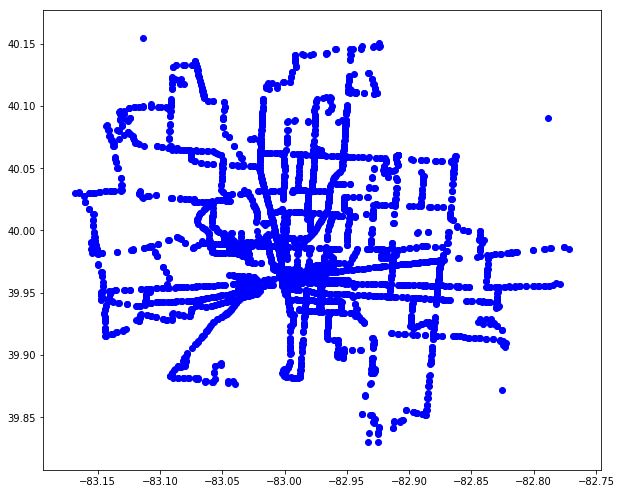

In [20]:
cota_stops.plot(color='b')

Looking at the plot, we can see that most bus stops correspond to major roadways in the Columbus area. 

### Address Data

Now that we've transformed the bus stop data into the state we'd like, let's begin working with the address data. 

We'll be working with a subset of the entire address dataset restricted to the 43222 zip code. To start, we can load the data directly from the file.  Note that the data is stored in the [GeoJSON](http://geojson.org/) format, making using of JSON but with a specific, geodata-related structure. Once we load the data, we can see the number of addresses contained in the data.

In [24]:
addresses = geopandas.read_file("./43222.geojson")
len(addresses)

2977

There are nearly 3,000 addressess contained in the dataset. Let's see what the first few records looks like and all the fields and values for the first record.

In [25]:
addresses.head(5)

,ADDR_ID,ADDR_NUM,CITY,COLS_KEY,COUNTY,DEVLPR_ID,FIPS_CODE,GIS_MAINT_AUTH,LAST_EDIT_DATE,LATITUDE,...,VANITY_NAME,Z_COORD,SUF_DIR,TENANT_NAME,BUILDING,COLL_DATE,UNIT_TYPE,PRE_TYPE,LOCAL_ID,geometry
0,1.800003e+11,192,COLUMBUS,269225.0,FRA,UNKNOWN,18000,1.0,2008-02-01T13:50:37,39.961862,...,None,NaN,None,None,None,None,None,None,NaN,POINT (-83.03724214276149 39.9618697100728)
1,1.800013e+11,99,COLUMBUS,1298499.0,FRA,215,18000,1.0,2010-04-14T11:46:53,39.955505,...,None,NaN,None,None,None,None,None,None,NaN,POINT (-83.03917252093056 39.95551295619109)
2,1.800003e+11,108,COLUMBUS,270014.0,FRA,UNKNOWN,18000,1.0,2008-02-01T13:50:35,39.959640,...,None,NaN,None,None,None,None,None,None,NaN,POINT (-83.04130524454116 39.95962579005274)
3,1.800011e+11,956,COLUMBUS,1061682.0,FRA,ACTIVE,18000,1.0,2008-02-01T14:10:36,39.959408,...,None,NaN,None,None,None,None,None,None,NaN,POINT (-83.02622859345237 39.95941599721341)
4,1.800001e+11,270,COLUMBUS,115331.0,FRA,UNKNOWN,18000,1.0,2008-02-01T13:42:58,39.953919,...,None,NaN,None,None,None,None,None,None,NaN,POINT (-83.02291959309909 39.9539266611331)


In [26]:
addresses.iloc[0]

ADDR_ID                                                1.8e+11
ADDR_NUM                                                   192
CITY                                                  COLUMBUS
COLS_KEY                                                269225
COUNTY                                                     FRA
DEVLPR_ID                                              UNKNOWN
FIPS_CODE                                                18000
GIS_MAINT_AUTH                                               1
LAST_EDIT_DATE                             2008-02-01T13:50:37
LATITUDE                                               39.9619
LONGITUDE                                             -83.0372
LSN                                             192 HAYDEN AVE
MP_VAL                                                0.279221
MSAG_LSN                                        192 HAYDEN AVE
NLFID                                           MFRAMR05477**C
OBJECTID                                               

Notice that the address data includes a *geometry* field that appears to contain point data in terms of longitude and latitude.  Most geospatial datasets will include a *geometry* field that includes *point*, *line*, or *polygon* data or a representation of square cells.  To see the details of the coordinate system being used, we can use the *crs* property again.

In [27]:
addresses.crs

{'init': 'epsg:4326'}

This is the system we'd like to work in so we don't need to transform the data before working with it. 

Let's look at the address data in relation to the bus stop data.  To plot both of them together, we first create *matplotlib* *figure* and *axes* objects.  The *axes* object will be stored in the *ax* variable and used with the *GeoDataFrame* *plot* method.  We'll plot bus stops with blue markers and addresses with red markers.

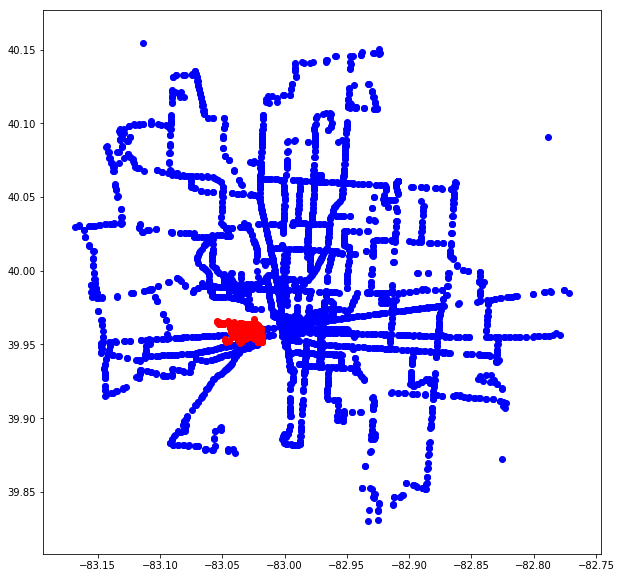

In [28]:
fig, ax = pyplot.subplots(1, 1)
cota_stops.plot(ax=ax, color='b')
addresses.plot(ax=ax, color='r')

Notice that the area that includes address points is much smaller than the area that contains all the bus stops.  We can filter the bus stop data by specifying bounds on the longitude and latitude.

In [29]:
cota_stops = cota_stops[(cota_stops.geometry.x >= -83.1) &
                                 (cota_stops.geometry.x <= -83.0) &
                                 (cota_stops.geometry.y >= 39.9) &
                                 (cota_stops.geometry.y <= 40.0)]
len(cota_stops)

520

We've reduced the number of bus stops to just over 500.  Let's update our plot of addresses and bus stops.

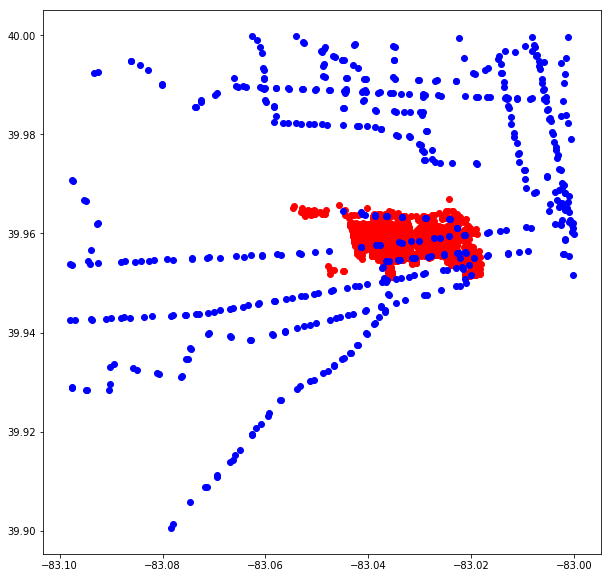

In [30]:
fig, ax = pyplot.subplots(1, 1)
addresses.plot(ax=ax, color='r')
cota_stops.plot(ax=ax, color='b')

### Greatest Minimum Distance

With the data loaded and the dataset pared down a bit, we can now consider the question we're trying to answer.  First, let's see how we can calculate the physical distance in miles between a bus stop and an address. 

In [31]:
a_stop = cota_stops.iloc[0].geometry
an_address = addresses.iloc[0].geometry
haversine.haversine((a_stop.y, a_stop.x), (an_address.y, an_address.x), miles=True)

3.0372506560359014

To use the *haversine* function, we had to rewrite the coordinates of each point as latitude/longitude pairs rather than longitude/latitude pairs.  This is a bit cumbersome so we can write our own function to calculate the distance between two points as they are stored in the datasets.

In [32]:
def distance(point_1, point_2):
    lat_lon_1 = (point_1.y, point_1.x)
    lat_lon_2 = (point_2.y, point_2.x)
    return haversine.haversine(lat_lon_1, lat_lon_2, miles=True)

Before we look at all addresses, let's think about how we'd calculate the distance to the nearest bus stop for one address.  We'll start by choosing one address to work with, which we will store in the *address_point* variable.  Next, we can create a variable to store the smallest distance between the address and a bus stop, let's call it *minimum_stop_distance*, and set to the distance between the address and the first bus stop. To find the smallest distances, we examine each bus stop and calculate the distance between it and the address.  If the calculated distance is smaller than *minimum_stop_distance* we'll replace the value of *minimum_stop_distance* with the new value; if not, we'll continue on to the next address.  After examining all the bus stops, we'll display the value of *minimum_stop_distance*.

In [33]:
address_point = addresses.iloc[0].geometry
minimum_stop_distance = distance(address_point, cota_stops.iloc[0].geometry)

for stop_point in cota_stops.geometry:
    stop_distance = distance(address_point, stop_point)
    if stop_distance < minimum_stop_distance:
        minimum_stop_distance = stop_distance
        
print("Miniumn stop distance:", minimum_stop_distance)

Miniumn stop distance: 0.1164577671147217


The result indicates that the nearest bus stop to the address we're working with is about one tenth of a mile away.  

Let's extend our code to look at all addresses, one at a time.  For each address, we'll calculate the distance to the nearest bus stop just like we did above.  Now that we're looking at all addresses, we'll also keep track of *greatest_minimum_distance*. We'll set *greatest_minimum_distance* to 0 initially.  For each address, we'll compare its distance to the nearest bus stop to *greatest_minimum_distance*.  If the distance to the nearest bus stop is greater than the value of *greatest_minimum_distance*, we'll replace the value of *greatest_minimum_distance* with the new value; if not, we'll continue to the next address. After working through all addresses, we'll display the value of *greatest_minimum_distance*.

The code below includes extra code to display the progress as it works through the calculations. The percentage is determined based on the index of the current address being processed divided by the total number of addresses.

In [34]:
number_of_addresses = len(addresses)
greatest_minimum_distance = 0
for index, address_point in enumerate(addresses.geometry):
    
    # display progress
    if index % 100 == 0:
        print("Percent complete: ", index/number_of_addresses * 100)
    
    minimum_stop_distance = distance(address_point, cota_stops.iloc[0].geometry)
    for stop_point in cota_stops.geometry:
        stop_distance = distance(address_point, stop_point)
        if stop_distance < minimum_stop_distance:
            minimum_stop_distance = stop_distance
    
    if minimum_stop_distance > greatest_minimum_distance:
        greatest_minimum_distance = minimum_stop_distance
print("Greatest miniumn distance:", greatest_minimum_distance)

Percent complete:  0.0
Percent complete:  3.359086328518643
Percent complete:  6.718172657037286
Percent complete:  10.077258985555929
Percent complete:  13.436345314074572
Percent complete:  16.795431642593215
Percent complete:  20.154517971111858
Percent complete:  23.5136042996305
Percent complete:  26.872690628149144
Percent complete:  30.231776956667787
Percent complete:  33.59086328518643
Percent complete:  36.94994961370507
Percent complete:  40.309035942223716
Percent complete:  43.66812227074236
Percent complete:  47.027208599261
Percent complete:  50.38629492777964
Percent complete:  53.74538125629829
Percent complete:  57.10446758481693
Percent complete:  60.46355391333557
Percent complete:  63.82264024185421
Percent complete:  67.18172657037286
Percent complete:  70.5408128988915
Percent complete:  73.89989922741015
Percent complete:  77.25898555592879
Percent complete:  80.61807188444743
Percent complete:  83.97715821296607
Percent complete:  87.33624454148472
Percent comp

From the result we can see that the greatest distance between an address in the 43222 zip code and its nearest bus stop is about half a mile. 

## Exercise
Calculate the mean distance to the nearest stop for all addresses in 43222.

**Hint**: Most of the code used to calculate the greatest minimum distance can be reused. Here's an updated form of the code above with some new variable names.

```python
number_of_addresses = len(addresses)
total_minimum_distance = 0
for index, address_point in enumerate(addresses.geometry):
    
    # display progress
    if index % 100 == 0:
        print("Percent complete: ", index/number_of_addresses * 100)
    
    minimum_stop_distance = distance(address_point, cota_stops.iloc[0].geometry)
    for stop_point in cota_stops.geometry:
        stop_distance = distance(address_point, stop_point)
        if stop_distance < minimum_stop_distance:
            minimum_stop_distance = stop_distance
    total_minimum_distance = total_minimum_distance + minimum_stop_distance

# MEAN CALCULATION CODE HERE

print("Mean minimumn distance:", mean_minimum_distance)
```

Replace "`# MEAN CALCULATION CODE HERE`" with the code needed to calculate `mean_minimum_distance` from `total_minimum_distance` and `number_of_addresses`.

Recall that the mean of a set of values is the sum of the values divided by the number of values.